In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pcigale import sed
from pcigale import sed_modules as modules
from copy import deepcopy
from astropy.table import Table
import pandas as pd
import timeit

In [3]:
%pylab inline
%config InlineBackend.figure_format='svg'
matplotlib.rcParams['figure.figsize'] = [11.,5.]

Populating the interactive namespace from numpy and matplotlib


In [4]:
def limit_spec(spectrum, L_min, L_max):
    wave, lum = spectrum['wavelength'],spectrum['Fnu']
    xmin, xmax = L_min, L_max 
    mask = (wave >= 0) 
    return wave[mask], lum[mask]

In [5]:
import random

In [6]:
n =1000
tau_main = 10**np.random.uniform(2,5,n)
age_main = np.random.uniform(501,10000,n)
tau_burst = np.random.uniform(100,10000,n) 
age_burst = 10**np.random.uniform(1,np.log10(500),n)
f_burst = np.random.uniform(0,0.05,n)
metallicity = random.choices([0.0001, 0.0004, 0.004, 0.008, 0.02,0.05],k=n)
logU = np.round(np.random.uniform(-3,-1,n),1)
f_esc = np.random.uniform(0.,0.5,n)
f_dust = np.random.uniform(0.,0.5,n)
lines_width = 300
E_BV_lines = random.choices([0.0, 0.01, 0.1, 0.5, 1.0],k=n)
E_BV_factor = 0.44
uv_bump_wavelength = 217.5
uv_bump_width = 35.0
uv_bump_amplitude = 0.0
powerlaw_slope = 0.0
Ext_law_emission_lines = 1
Rv = 3.1
qpah = random.choices([ 0.47, 1.12, 1.77,2.50, 3.19, 3.90, 4.58, 5.26, 5.95, 6.63, 7.32],k=n)
umin = random.choices([0.100, 0.120, 0.150, 0.170, 0.200, 0.250,
                       0.300, 0.350, 0.400, 0.500, 0.600, 0.700,
                       0.800, 1.000, 1.200, 1.500, 1.700, 2.000,
                       2.500, 3.000,3.500, 4.000, 5.000, 6.000,
                       7.000, 8.000, 10.00, 12.00, 15.00,17.00,
                       20.00, 25.00, 30.00, 35.00, 40.00, 50.00],k=n)
alpha = np.round(np.random.uniform(1.0,3,n),1)
gamma = np.random.uniform(0.,1.,n)
params = pd.DataFrame({"deep_sfhdelayed.tau_main" : tau_main,
                     "deep_sfhdelayed.age_main" : age_main,
                     "deep_sfhdelayed.tau_burst" : tau_burst,
                     "deep_sfhdelayed.age_burst" : age_burst,
                     "deep_sfhdelayed.f_burst" : f_burst,
                     "deep_sfhdelayed.sfr_A" : 1.0,
                     "deep_bc03.imf" : 1,
                     "deep_bc03.metallicity" : metallicity})
params.to_csv("params_comparison.txt", index = False, sep = " ")

In [7]:
params_test = params.iloc[0]

In [8]:
params_test["deep_sfhdelayed.tau_main"]

16759.52965806513

In [9]:
from multiprocessing import Pool, set_start_method
set_start_method("fork")

In [10]:
def True_mod_nebular(i):
    gal2 = sed.SED()
    mod2 = modules.get_module('sfhdelayed', tau_main=tau_main[i],
                             age_main = age_main[i],
                             tau_burst=tau_burst[i],
                             age_burst =age_burst[i],
                             f_burst=f_burst[i],
                             sfr_A = 1.0)
    mod2.process(gal2)
    mod2 = modules.get_module('bc03', 
                              imf=1, 
                              metallicity=metallicity[i])
    mod2.process(gal2)
    mod2 = modules.get_module('nebular',
                              logU = logU[i], 
                              f_esc = f_esc[i],
                              f_dust= f_dust[i], 
                              lines_width = 300, 
                              emission = "True")
    mod2.process(gal2)
    return False
def timer_True_mod_nebular():
    with Pool(10) as p:
           p.map(True_mod_nebular, range(n))

In [11]:
def deep_mod_nebular():
    for i in range(n):
        gal2 = sed.SED()
        mod2 = modules.get_module('deep_sfhdelayed', tau_main=tau_main[i],
                                 age_main = age_main[i],
                                 tau_burst=tau_burst[i],
                                 age_burst =age_burst[i],
                                 f_burst=f_burst[i],
                                 sfr_A = 1.0)
        mod2.process(gal2)
        mod2 = modules.get_module('deep_bc03_pca_norm', 
                                  imf=1, 
                                  metallicity=metallicity[i])
        mod2.process(gal2)
        mod2 = modules.get_module('nebular',
                                  logU = logU[i], 
                                  f_esc = f_esc[i],
                                  f_dust= f_dust[i], 
                                  lines_width = 300,
                                  emission = "True")
        mod2.process(gal2)
    return False

In [12]:
def fake_mod_nebular(i):
    gal2 = sed.SED()
    mod2 = modules.get_module('deep_sfhdelayed',
                              tau_main=tau_main[i],
                             age_main = age_main[i],
                             tau_burst=tau_burst[i],
                             age_burst =age_burst[i],
                             f_burst=f_burst[i],
                             sfr_A = 1.0)
    mod2.process(gal2)
    mod2 = modules.get_module('fake_bc03',
                              imf=1,
                              metallicity=metallicity[i])
    mod2.process(gal2)
    mod2 = modules.get_module('nebular',
                              logU = logU[i], 
                              f_esc = f_esc[i],
                              f_dust= f_dust[i], 
                              lines_width = 300,
                              emission = "True")
    mod2.process(gal2)
    return False
def timer_fake_mod_nebular():
    with Pool(10) as p:
           p.map(fake_mod_nebular, range(n))

In [13]:
def fake_mod_red(i):
    
    gal2 = sed.SED()
    mod2 = modules.get_module('deep_sfhdelayed', 
                              tau_main=tau_main[i],
                             age_main = age_main[i],
                             tau_burst=tau_burst[i],
                             age_burst =age_burst[i],
                             f_burst=f_burst[i],
                             sfr_A = 1.0)
    mod2.process(gal2)
    mod2 = modules.get_module('fake_bc03', 
                              imf=1,
                              metallicity=metallicity[i])
    mod2.process(gal2)
    mod2 = modules.get_module('redshifting',
                              redshift  = 1)
    mod2.process(gal2)
    return False
def timer_fake_mod_red():
    with Pool(10) as p:
           p.map(fake_mod_red, range(n))

In [14]:
def fake_mod_dl2014_red(i):
    gal2 = sed.SED()
    mod2 = modules.get_module('deep_sfhdelayed',
                              tau_main=tau_main[i],
                             age_main = age_main[i],
                             tau_burst=tau_burst[i],
                             age_burst =age_burst[i],
                             f_burst=f_burst[i],
                             sfr_A = 1.0)
    mod2.process(gal2)
    mod2 = modules.get_module('fake_bc03',
                              imf=1, 
                              metallicity=metallicity[i])
    mod2.process(gal2)
    mod2= modules.get_module('dl2014',
                             qpah = qpah[i],
                             umin = umin[i],
                             alpha = alpha[i],
                             gamma = gamma[i])
    mod2 = modules.get_module('redshifting',
                              redshift  = 1)
    mod2.process(gal2)
    return False
def timer_fake_mod_dl2014_red():
    with Pool(10) as p:
           p.map(fake_mod_dl2014_red, range(n))

In [15]:
def fake_mod_Dust_dl2014_red(i):
    gal2 = sed.SED()
    mod2 = modules.get_module('deep_sfhdelayed',
                              tau_main=tau_main[i],
                             age_main = age_main[i],
                             tau_burst=tau_burst[i],
                             age_burst =age_burst[i],
                             f_burst=f_burst[i],
                             sfr_A = 1.0)
    mod2.process(gal2)
    mod2 = modules.get_module('fake_bc03',
                              imf=1,
                              metallicity=metallicity[i])
    mod2.process(gal2)
    mod2 = modules.get_module('dustatt_modified_starburst',
                              E_BV_lines = 0.1, 
                              E_BV_factor = 0.44,
                              uv_bump_wavelength = 217.5,
                              uv_bump_width = 35.0,
                              uv_bump_amplitude = 0.0,
                              powerlaw_slope = 0.0,
                              Ext_law_emission_lines = 1,
                              Rv = 3.1,
                              filters = "B_B90 & V_B90 & FUV")
    mod2.process(gal2)
    mod2= modules.get_module('dl2014',
                             qpah = qpah[i],
                             umin = umin[i],
                             alpha = alpha[i],
                             gamma = gamma[i])
    mod2 = modules.get_module('redshifting',
                              redshift  = 1)
    mod2.process(gal2)
    return False
def timer_fake_mod_Dust_dl2014_red():
    with Pool(10) as p:
           p.map(fake_mod_Dust_dl2014_red, range(n))

In [16]:
import time

In [23]:
t1 = timeit.Timer("timer_fake_mod_red()", globals=globals())

t2 = timeit.Timer("deep_mod_nebular()", globals=globals())
t3 = timeit.Timer("timer_fake_mod_nebular()", globals=globals())
t4 = timeit.Timer("timer_True_mod_nebular()", globals=globals())
t5 = timeit.Timer("timer_fake_mod_dl2014_red()", globals=globals())
t6 = timeit.Timer("timer_fake_mod_Dust_dl2014_red()", globals=globals())
print("fake + red =",t1.timeit(1))
time.sleep(5)
print("deep + Neb =",t2.timeit(1))
time.sleep(5)
print("fake + Neb =",t3.timeit(1))
time.sleep(5)
#print("True + Neb =",t4.timeit(1)) takes a few minutes
time.sleep(5)
print("fake + dl2014 + red =",t5.timeit(1))
time.sleep(5)
print("fake + Dust + dl2014 + red =",t6.timeit(1))
time.sleep(5)

fake + red = 1.2154519129981054
deep + Neb = 49.66973293200135
fake + Neb = 7.96617117599817
fake + dl2014 + red = 1.7375663870043354
fake + Dust + dl2014 + red = 2.1326929200004088


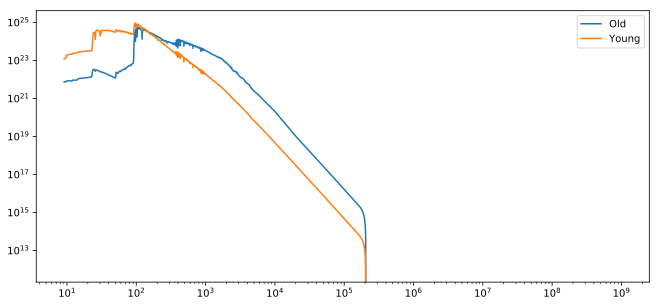

In [18]:
gal = sed.SED()
mod = modules.get_module('sfhdelayed', 
                         tau_main=tau_main[0],
                         age_main = age_main[0],
                         tau_burst=tau_burst[0],
                         age_burst =age_burst[0],
                         f_burst=f_burst[0],
                         sfr_A = 1.0)
mod.process(gal)
mod = modules.get_module('bc03', 
                         imf=1,
                         metallicity=metallicity[0])
mod.process(gal)
mod = modules.get_module('nebular',
                         logU = logU[0], 
                         f_esc = f_esc[0],
                         f_dust= f_dust[0] , 
                         lines_width = 300,
                         emission = "True")
mod.process(gal)
mod = modules.get_module('dustatt_modified_starburst',
                          E_BV_lines = 0.1, 
                          E_BV_factor = 0.44,
                          uv_bump_wavelength = 217.5,
                          uv_bump_width = 35.0,
                          uv_bump_amplitude = 0.0,
                          powerlaw_slope = 0.0,
                          Ext_law_emission_lines = 1,
                          Rv = 3.1,
                          filters = "B_B90 & V_B90 & FUV")
mod.process(gal)
mod= modules.get_module('dl2014',
                         qpah = qpah[0],
                         umin = umin[0],
                         alpha = alpha[0],
                         gamma = gamma[0])
mod.process(gal)
plt.loglog(gal.wavelength_grid, gal.get_lumin_contribution('stellar.old'), label="Old")
plt.loglog(gal.wavelength_grid, gal.get_lumin_contribution('stellar.young'), label="Young")
plt.legend()

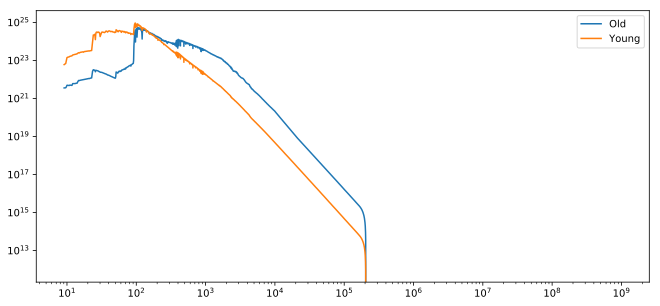

In [19]:
gal2 = sed.SED()
mod2 = modules.get_module('deep_sfhdelayed',
                          tau_main=tau_main[0],
                         age_main = age_main[0],
                         tau_burst=tau_burst[0],
                         age_burst =age_burst[0],
                         f_burst=f_burst[0],
                         sfr_A = 1.0)
mod2.process(gal2)
mod2 = modules.get_module('deep_bc03', 
                          imf=1, 
                          metallicity=metallicity[0])
mod2.process(gal2)
mod2 = modules.get_module('nebular',
                          logU = logU[0], 
                          f_esc = f_esc[0],
                          f_dust= f_dust[0] , 
                          lines_width = 300,
                          emission = "True")
mod2.process(gal2)
mod2 = modules.get_module('dustatt_modified_starburst',
                          E_BV_lines = 0.1, 
                          E_BV_factor = 0.44,
                          uv_bump_wavelength = 217.5,
                          uv_bump_width = 35.0,
                          uv_bump_amplitude = 0.0,
                          powerlaw_slope = 0.0,
                          Ext_law_emission_lines = 1,
                          Rv = 3.1,
                          filters = "B_B90 & V_B90 & FUV")
mod2.process(gal2)
mod2= modules.get_module('dl2014',
                         qpah = qpah[0],
                         umin = umin[0],
                         alpha = alpha[0],
                         gamma = gamma[0])
mod2.process(gal2)
plt.loglog(gal2.wavelength_grid, gal2.get_lumin_contribution('stellar.old'), label="Old")
plt.loglog(gal2.wavelength_grid, gal2.get_lumin_contribution('stellar.young'), label="Young")
plt.legend()

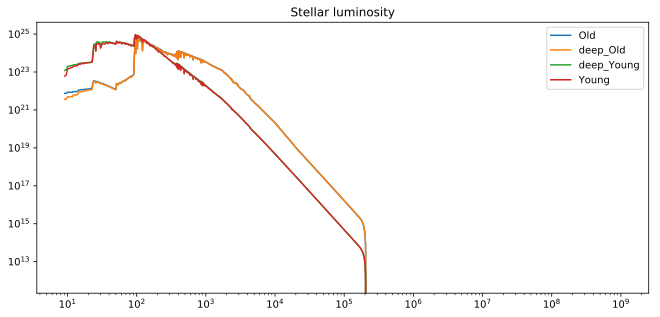

In [20]:
plt.loglog(gal.wavelength_grid, gal.get_lumin_contribution('stellar.old'), label="Old")
plt.loglog(gal2.wavelength_grid, gal2.get_lumin_contribution('stellar.old'), label="deep_Old")
plt.loglog(gal.wavelength_grid, gal.get_lumin_contribution('stellar.young'), label="deep_Young")
plt.loglog(gal2.wavelength_grid, gal2.get_lumin_contribution('stellar.young'), label="Young")
plt.legend()
plt.title("Stellar luminosity")
plt.savefig("deep_true_stellar.png")

In [21]:
mod = modules.get_module('redshifting', redshift  = 1)
mod.process(gal)
mod2 = modules.get_module('redshifting', redshift  = 1)
mod2.process(gal2)

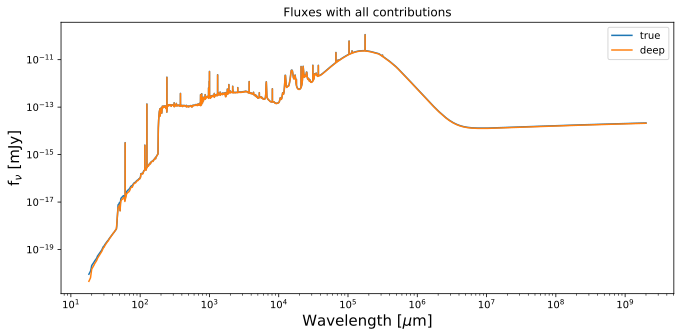

In [22]:
plt.loglog(gal.wavelength_grid, gal.fnu, label="true")
plt.loglog(gal2.wavelength_grid, gal2.fnu, label="deep")
plt.xlabel('Wavelength [$\mu$m]', fontsize = 15)
plt.ylabel(r'f$_\nu$ [mJy]', fontsize = 15);
plt.legend()
plt.title("Fluxes with all contributions")
plt.savefig("deep_true_fluxes.png")